# Grouping Venue Categories

I will use natural language processing tools here to try and infer the inherent structure/clusters of these venues. This can be useful later on to create features for modeling the proportion of establishments in a city. 

## Import libraries and data

In [47]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
import seaborn as sns

df = pd.read_pickle('venue_list.pkl')

## Exploration

In [40]:
df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Butuan,8.95,125.53,Wat Ever Family KTV Butuan,8.946194,125.531061,Karaoke Bar
1,Butuan,8.95,125.53,Boy's Beer & Wine Room,8.946217,125.531236,Beer Garden
2,Butuan,8.95,125.53,Watergate Hotel,8.951037,125.529557,Hotel
3,Butuan,8.95,125.53,Almont Inland Resort Butuan,8.946409,125.529393,Resort
4,Butuan,8.95,125.53,Margie's,8.947072,125.535636,Café


In [46]:
print('There are currently ' + str(len(np.unique(df['Venue Category']))) + ' venue category types')

There are currently 215 venue category types


shown below are the top 20 venue categories.

In [52]:
df['Venue Category'].value_counts()[0:21]

Café                    626
Hotel                   599
Coffee Shop             586
Filipino Restaurant     538
Shopping Mall           349
Pizza Place             308
Resort                  296
Restaurant              289
Fast Food Restaurant    286
Japanese Restaurant     241
Bakery                  238
BBQ Joint               235
Seafood Restaurant      182
Dessert Shop            174
Asian Restaurant        166
Clothing Store          163
Beach                   155
Steakhouse              154
Italian Restaurant      145
Park                    132
Spa                     114
Name: Venue Category, dtype: int64

## Word embedding determination

at this point, using the unique venue categories, I will determine the corresponding embeddings of each phrase/word to be used for clustering later on.

### Word2Vec

A word2vec pre-trained model was used that was trained on google news dataset containing 3 million words and phrases. The output for this is a 300-dimensional column vector.

In [5]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

Test to see if the model works:

In [58]:
vc_tst = model['Restaurant']
vc_tst.shape

(300,)

For each unique venue category, determined the corresponding word embedding vector for it. Since most of the categories are phrases, I will try taking first taking the average of the output vectors for each word in a phrase. See example for the venue category *japanese restaurant*:

In [77]:
vec_list = np.array([model[x] for x in 'japanese restaurant'.split(' ')])
vec_mean = np.mean(np.array(vec_list), axis = 0)
vec_mean.shape




(300,)

Showing the first 20 elements of the vector:

In [79]:
vec_mean[0:20]

array([-0.07556915, -0.0402832 ,  0.10070801,  0.32910156, -0.18383789,
        0.06420898, -0.0144043 , -0.01531982,  0.19873047,  0.01269531,
       -0.08886719, -0.18786621,  0.04711914, -0.28955078, -0.1048584 ,
        0.00390625, -0.08789062,  0.1824646 ,  0.05456543, -0.07641602],
      dtype=float32)

### Determine word embeddings using pre-trained model

I will pre-process first the venue category list to remove any special characters in the unique venue category list.

In [164]:
import re
venue_cat_unique = np.unique(df['Venue Category'])

punct_bool =[]
for venue in venue_cat_unique:
    bool_ = bool(re.search(r'[((/+*\-))]', venue)) #finding special characters
    punct_bool.append(bool_)


print("There are " + str(np.sum(punct_bool)) + " strings with special characters")
        

There are 9 strings with special characters


In [165]:
venue_cat_unique[np.where(np.array(punct_bool) == True)]

array(['Cajun / Creole Restaurant', 'Deli / Bodega',
       'Gym / Fitness Center', 'Harbor / Marina', 'Monument / Landmark',
       'Residential Building (Apartment / Condo)', 'Salon / Barbershop',
       'Tex-Mex Restaurant', 'Vegetarian / Vegan Restaurant'],
      dtype=object)

I now remove special characters or punctuation marks from these venue names and convert to spaces.

In [166]:
indWithPunct = np.where(np.array(punct_bool) == True)[0]

for ind in indWithPunct:
    new_venue = re.sub(
        r'\s{2,}', #remove excess spaces
        ' ',
        re.sub(r'[((/+*\-))]', '', venue_cat_unique[ind]) # remove punctuation marks
    )
        
    
    venue_cat_unique[ind] = new_venue

venue_cat_unique[indWithPunct]

array(['Cajun Creole Restaurant', 'Deli Bodega', 'Gym Fitness Center',
       'Harbor Marina', 'Monument Landmark',
       'Residential Building Apartment Condo', 'Salon Barbershop',
       'TexMex Restaurant', 'Vegetarian Vegan Restaurant'], dtype=object)

#### Averaging Word Embeddings

In [167]:
word_embed = []
for venue in venue_cat_unique:
    vec_list = np.array([model[i] for i in venue.split(' ')])
    ave_vec = np.mean(vec_list, axis = 0)
    word_embed.append(ave_vec)


In [172]:
arr_embed = np.array(word_embed)
arr_embed.shape

(215, 300)

## K-means clustering

Now that I have the corresponding average word embedding vectors for each venue category, I now cluster these categories using K-means.

In [192]:
from sklearn.cluster import KMeans
n_clusters =range(1,51)
wss = []

for k in n_clusters:
    clust = KMeans(n_clusters = k)
    clust.fit(arr_embed)
    wss.append(clust.inertia_)

smr_k_means = pd.DataFrame({'k':n_clusters, 'wss':wss})

smr_k_means.head()

    

,k,wss
0,1,1232.314087
1,2,1136.707075
2,3,1088.412453
3,4,1061.225159
4,5,1034.660845


Shown below is an attempt to determine optimal clusters for K-means. It seems that decrease of withing cluster residuals just keeps on decreasing with increasing k.

Text(0.5, 1.0, 'Within Cluster Residuals vs. Cluster size')

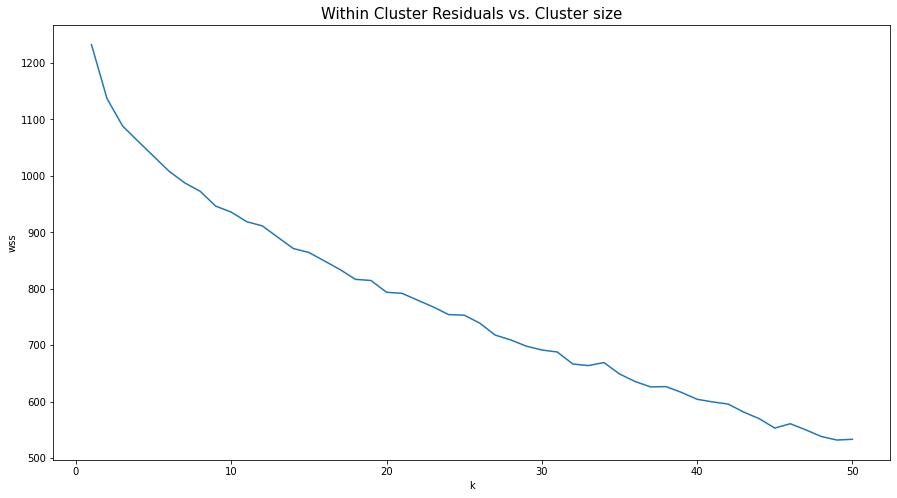

In [271]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15, 8))
lp = sns.lineplot(x = 'k', y = 'wss', data = smr_k_means)
lp.set_title('Within Cluster Residuals vs. Cluster size', fontsize = 15)


### Setting it by hand

Since the elbow method does not make sense in this case, I will try to iteratively determine clusters starting with $k = 5$ and see what makes sense. To help in determination, I will do PCA to reduce dimensionality to two.

In [208]:
from sklearn.decomposition import PCA

pc_decmp = PCA(n_components = 5)
pca_result = pc_decmp.fit_transform(arr_embed)

df_unique_venue = pd.DataFrame({'venue_category':venue_cat_unique})

df_unique_venue['pc_one'] = pca_result[:,0]
df_unique_venue['pc_two'] = pca_result[:,1]

pc_decmp.explained_variance_ratio_


array([0.10071039, 0.05674446, 0.04542281, 0.03826414, 0.03288147],
      dtype=float32)

In [254]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = df_unique_venue.pc_one,
        y = df_unique_venue.pc_two,
        hovertext = df_unique_venue.venue_category,
        mode ='markers'
    )
)

fig.update_layout(
    autosize =False,
    width = 1000,
    height = 800,
    template = 'plotly_white',
    title = 'Principal Component Visualization of Venue Categories'
)

fig.show()

In [219]:
kClust5 = KMeans(n_clusters = 5)
kClust5.fit(arr_embed)
cl = kClust5.predict(arr_embed)
df_unique_venue['cl'] = cl
cl

array([2, 4, 1, 2, 4, 4, 4, 3, 2, 4, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 3,
       4, 4, 4, 0, 1, 0, 3, 2, 4, 0, 2, 4, 2, 2, 2, 1, 3, 4, 0, 2, 4, 4,
       3, 1, 3, 4, 2, 3, 4, 3, 2, 3, 2, 3, 3, 2, 2, 1, 3, 0, 3, 2, 3, 2,
       2, 0, 3, 2, 4, 2, 3, 3, 3, 3, 4, 0, 4, 2, 0, 3, 3, 0, 4, 2, 4, 2,
       3, 4, 2, 3, 4, 4, 0, 3, 4, 4, 3, 1, 1, 0, 0, 1, 1, 1, 3, 2, 2, 0,
       2, 2, 1, 1, 2, 2, 0, 0, 1, 2, 3, 4, 2, 2, 2, 3, 3, 2, 4, 1, 0, 4,
       4, 4, 4, 3, 4, 4, 4, 2, 1, 0, 4, 3, 0, 4, 4, 4, 4, 4, 4, 3, 0, 2,
       4, 4, 1, 4, 4, 0, 2, 4, 1, 2, 0, 4, 2, 3, 0, 0, 4, 4, 2, 3, 3, 3,
       0, 0, 1, 2, 0, 4, 3, 1, 4, 2, 4, 3, 0, 2, 2, 0, 2, 2, 4, 4, 4, 4,
       4, 0, 0, 2, 4, 2, 2, 0, 0, 3, 4, 0, 0, 1, 0, 4, 4], dtype=int32)

In [275]:
import plotly.express as px
df_unique_venue['cl_str'] = df_unique_venue.cl.apply(str)
fig = px.scatter(df_unique_venue, x = 'pc_one', y = 'pc_two', color = 'cl_str', width = 900,
                height = 800, hover_name = 'venue_category', template = 'plotly_white',
                color_discrete_sequence = px.colors.qualitative.Set1,
                title = 'Principal Components Visualization with Cluster Labels')
fig.update_layout(xaxis_title = '1st Principal Component', yaxis_title = '2nd Principal Component')
fig.show()

It can be observed in the plot above that there are still overlap in some clusters but there seems to be some evident topic for each cluster:
 + Cluster 0 - Nature-related venues (Volcano, Lake, river etc.)
 + Cluster 1 - Tourist/Vacation amenities (Hotel, Airport Lounge, Bar, Hostel)
 + Cluster 2 - Restaurants
 + Cluster 3 - Lifestyle venues
 + Cluster 4 - City-Related Venues 
 
 But again, there are still some overlaps in these clusters and ambiguities on how you would classifiy a specific venue.

## Clustering using DBSCAN

In [330]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import dbscan

dbscan = DBSCAN(eps = 2, min_samples = 2) # for now use the default settings
dbscan.fit(arr_embed)


DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [331]:
dbscan.labels_

array([ 0, -1, -1,  0, -1,  1,  1,  0,  0,  2,  0,  3, -1,  2, -1,  2,  2,
        4,  5, -1, -1, -1,  5, -1, -1,  4, -1, -1,  0, -1,  6,  3,  7, -1,
       -1, -1, -1, -1,  0,  6, -1,  0, -1, -1,  0,  2,  0, -1,  0,  0, -1,
       -1, -1,  0,  0,  0,  0,  0, -1,  2,  2,  2,  0,  0,  0,  0,  0, -1,
       -1,  0, -1,  0,  0, -1,  0,  0,  0, -1, -1,  0,  3,  0,  0,  5, -1,
       -1, -1,  0,  0, -1,  0,  0,  8,  8, -1,  0, -1,  1,  0,  2, -1,  3,
        3,  2,  2,  2,  0,  0,  0, -1,  0,  0,  2, -1,  0,  0, -1, -1, -1,
        0, -1,  9,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  1, 10, 11,
       12, -1, -1,  0, -1, -1, -1, -1,  0, -1,  0,  5,  0, 12, 10, -1, -1,
        7, 13, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1,  7, 11,  7, -1,
       -1,  5,  0,  0, 13, 13,  7,  7, -1,  0, -1, -1, -1,  2,  2, -1, -1,
       -1,  2,  0,  7, -1,  0,  0, -1, 12, -1, -1, -1, -1, -1,  0, -1, -1,
        0, -1, -1,  0, 12, -1, -1,  2,  3,  9, -1])

In [332]:
df_unique_venue['cl_db'] = [str(cl) for cl in dbscan.labels_]

In [333]:
df_unique_venue.head()

,venue_category,pc_one,pc_two,cl,cl_str,cl_db
0,African Restaurant,0.870509,-0.408605,2,2,0
1,Airport,-0.605847,-0.281582,4,4,-1
2,Airport Lounge,0.167911,-0.217812,1,1,-1
3,American Restaurant,0.871482,-0.416676,2,2,0
4,Arcade,-0.322276,0.474492,4,4,-1


In [334]:
fig = px.scatter(df_unique_venue, x = 'pc_one', y = 'pc_two', color = 'cl_db', width = 900,
                height = 800, hover_name = 'venue_category', template = 'plotly_white',
                color_discrete_sequence = px.colors.qualitative.Set1,
                title = 'Principal Components Visualization with Cluster Labels (DBSCAN)')
fig.update_layout(xaxis_title = '1st Principal Component', yaxis_title = '2nd Principal Component')
fig.show()